In [7]:
!pip install numpy 
#!pip install torch torchvision torchaudio


ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random


In [3]:
import numpy as np
import math
import random
from graphviz import Digraph
#import torch

In [2]:
#Original micrograd engine and grapher for it
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | %4f | Gradient: %2f}" % (n.label, n.data, n.grad), shape = 'record')
        if n.operation:
            dot.node(name = uid + n.operation, label = n.operation)
            dot.edge(uid + n.operation, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.operation)

    return dot
class Value:


    def __init__(self, _data, _children=(), _operation = '', label = ''):
        self.data = _data
        self.grad = 0
        self.prev = set(_children)
        self._backprop = lambda: None
        self.operation = _operation
        self.label = label

    def __repr__(self):
        return (f"{self.label} = {self.data}")
    
    def backprop(self):
        self.grad = 1.0
        topo = []
        visited = []
        def build_topo(v):
            if v not in visited:
                visited.append(v)
                for child in v.prev:
                    child.grad=0  #To ensure gradient of all nodes is 0 before calling backpropagate
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for current in reversed(topo):

            current._backprop()

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + -(other)

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out_data = self.data + other.data
        out = Value(out_data, (self, other), '+')

        def _backprop():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backprop = _backprop

        return out
    
    def __radd__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out_data = self.data * other.data
        out = Value(out_data, (self, other), '*')

        def _backprop():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backprop = _backprop

        return out
    
    def __rmul__(self, other):
        return self * other
    

    
    def tanh(self):
        out_data = (math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1)
        out = Value(out_data, (self, ), 'tanh')

        def _backprop():
            self.grad += (1 - out_data**2) * out.grad
        out._backprop = _backprop

        return out

    def __pow__(self, exp):
        assert isinstance(exp, (int, float))
        out_data = self.data ** exp
        out = Value(out_data, (self, ), '**')

        def _backprop():
            self.grad += (exp * self.data ** (exp-1)) * out.grad
        out._backprop = _backprop

        return out
    
    def exp(self):
        out_data = math.exp(self.data)
        out = Value(out_data, (self, ), "exp")

        def _backprop():
            self.grad += out_data * out.grad
        out._backprop = _backprop

        return out

    def __truediv__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out_data = self.data / other.data
        out = Value(out_data, (self, other), '/')

        def _backprop():
            self.grad += (1 / other.data) * out.grad
            other.grad += (-self.data / (other.data**2)) * out.grad
        out._backprop = _backprop

        return out
    

In [98]:
#Neuron class utilising the previous Value class
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.bias = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.bias)
        out = act.tanh()
        return out
    

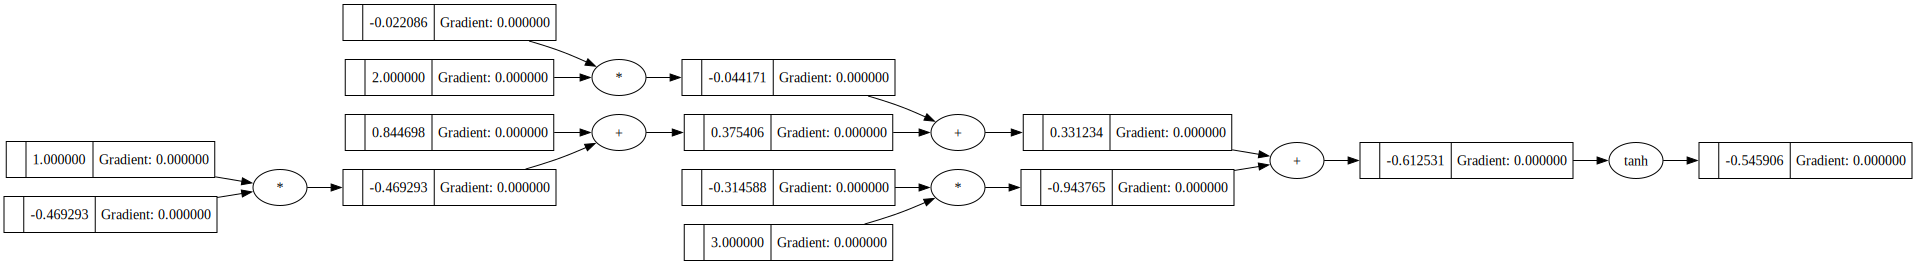

In [99]:
X = [1.0, 2.0, 3.0]
n = Neuron(3)
draw_dot(n(X))

In [100]:
#Layer class utilising the previous Neuron class
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        act = [neuron(x) for neuron in self.neurons]
        return act
    

In [101]:

L = Layer(3,3)
L(X)


[ = -0.8729264976018307,  = 0.9999465733221188,  = -0.918573536828767]

In [102]:
#Now finally the Multi-Layer Perceptron itself(MLP)
#we take numbers of outputs of each layer = nsout instead of nout. nsout is a list of numbers.
class MLP:
    def __init__(self, nin, nsout):
        # Single list that determines the number of inputs and number of neurons in each layer. 
        # eg. [3,4,5,6,1] : layer1(3,4), layer2(4,5), layer3(5,6), layer4(6,1)
        size_list = [nin] + nsout 
        self.layers = [Layer(size_list[i], size_list[i+1]) for i in range(len(nsout))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x[0] if len(x) == 1 else x
        return x

In [103]:
#2 inputs nodes, 3 layers and 1 output node.
_nin = 3
_nsout = [4,5,6,1] 
m = MLP(_nin, _nsout)
final = m(X)
final

 = 0.5946664132208326

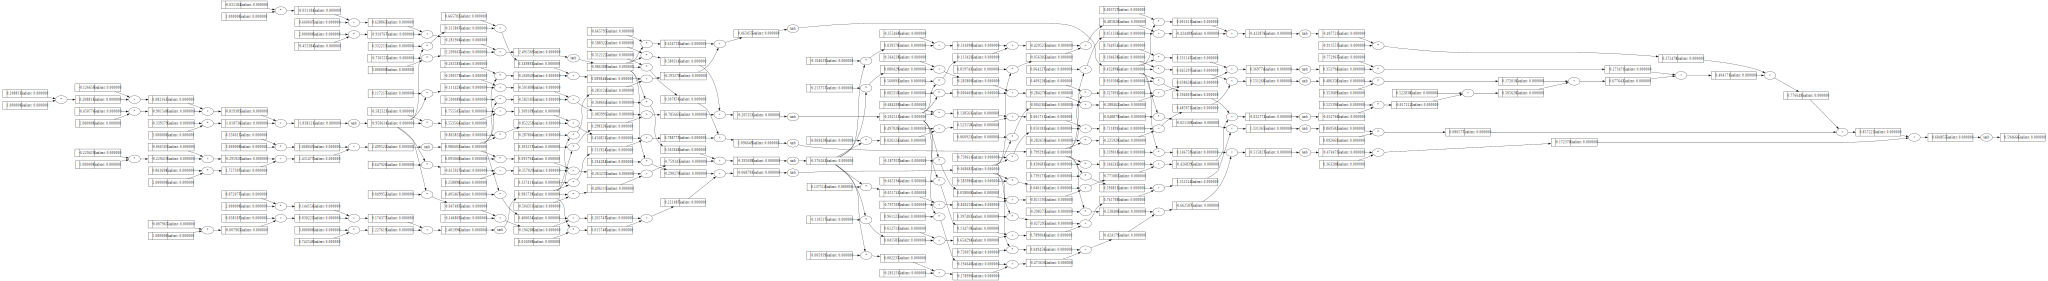

In [104]:
draw_dot(final)

In [105]:
Xs = [ 
    [2.0, 3.0, -1.0],
    [3.0, -1.0, -0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
    ]

Ys = [1.0, -1.0, -1.0, 1.0]
Ypredicted = [m(X) for X in Xs]
Ypredicted


[ = 0.7502360089729619,
  = 0.8466398024105081,
  = 0.6298883880919747,
  = 0.7782582048833532]

In [106]:

Loss = sum((ypredicted - ys)**2 for ys, ypredicted in zip(Ys, Ypredicted))
Loss

 = 6.178166192399083

In [107]:
#Now we need to minimise this loss by backpropagating, and updating gradient of parameters.
#Lets add method to collect parameters.

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.bias = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.bias)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.bias]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        act = [neuron(x) for neuron in self.neurons]
        return act
    
    def parameters(self):
        params = [param for neuron in self.neurons for param in neuron.parameters()]
        return params
        
    
class MLP:
    def __init__(self, nin, nsout):
        # Single list that determines the number of inputs and number of neurons in each layer. 
        # eg. [3,4,5,6,1] : layer1(3,4), layer2(4,5), layer3(5,6), layer4(6,1)
        size_list = [nin] + nsout 
        self.layers = [Layer(size_list[i], size_list[i+1]) for i in range(len(nsout))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x[0] if len(x) == 1 else x
        return x
    
    def parameters(self):
        params = [param for layer in self.layers for param in layer.parameters()]
        return params

In [108]:
_nin = 3
_nsout = [4,5,6,1] 
m = MLP(_nin, _nsout)

In [110]:
parameters = m.parameters()
parameters

[ = -0.26819462079783585,
  = -0.985815295612831,
  = 0.010236808918913542,
  = -0.2052383426401323,
  = -0.899624637895637,
  = 0.9443921345076844,
  = 0.12934379365490756,
  = 0.7905145826646482,
  = -0.0568349007469815,
  = 0.4948814663407002,
  = -0.7637369116279769,
  = 0.6058766862422222,
  = 0.4260081339415489,
  = 0.699831660274284,
  = 0.2945092601802868,
  = -0.7435374434852524,
  = -0.7578569854315749,
  = -0.17293791804435954,
  = 0.5202832506045241,
  = 0.922140178937741,
  = -0.8086268759191468,
  = -0.6284168735567524,
  = 0.26699185495119204,
  = -0.8431909322538191,
  = 0.6495473953813815,
  = -0.16218515276582468,
  = -0.7162398028461445,
  = 0.650396282965563,
  = 0.5597224545633628,
  = -0.5958728443356742,
  = 0.9009703523940251,
  = -0.8854864900550317,
  = 0.8854140971364612,
  = 0.03908313712631584,
  = -0.6690352938636388,
  = 0.45314138813119254,
  = 0.14515980595781164,
  = -0.9290549574054521,
  = 0.4337602244868868,
  = -0.6912455151897061,
  = 0.0800184751

In [129]:
Xs = [ 
    [2.0, 3.0, -1.0],
    [3.0, -1.0, -0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
    ]

Ys = [1.0, -1.0, -1.0, 1.0]
Ypredicted = [m(X) for X in Xs]
Ypredicted

[ = 0.8430099733548603,
  = -0.937704204186123,
  = -0.6747626362985204,
  = 0.8255824742784513]

In [130]:
Loss = sum((ypredicted - ys)**2 for ys, ypredicted in zip(Ys, Ypredicted))
Loss

 = 0.16472745066844152

In [131]:
#Backward pass to update gradients
def backward_pass():
    Loss.backprop()

backward_pass()

In [128]:
#Applying Gradient Descent
def forward_pass():
    for param in parameters:
        param.data += -0.1*param.grad

forward_pass()


In [4]:
#This was all manual. We gotta put this on a loop and make something like model.fit()

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.bias = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.bias)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.bias]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        act = [neuron(x) for neuron in self.neurons]
        return act
    
    def parameters(self):
        params = [param for neuron in self.neurons for param in neuron.parameters()]
        return params
        
    
class MLP:
    def __init__(self, nin, nsout):
        # Single list that determines the number of inputs and number of neurons in each layer. 
        # eg. [3,4,5,6,1] : layer1(3,4), layer2(4,5), layer3(5,6), layer4(6,1)
        size_list = [nin] + nsout 
        self.layers = [Layer(size_list[i], size_list[i+1]) for i in range(len(nsout))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x[0] if len(x) == 1 else x
        return x
    
    def parameters(self):
        params = [param for layer in self.layers for param in layer.parameters()]
        return params
    
    def fit(self, X, Y, epochs):
        for _ in range(epochs):
            Ypredicted = [self(x) for x in X]
            Loss = sum((ypredicted - ys)**2 for ys, ypredicted in zip(Y, Ypredicted))
            Loss.backprop()
            for param in self.parameters():
                param.data += -0.1*param.grad
        return Loss
    
    def predict(self, X):
        Ypredicted = [self(x) for x in X]
        return Ypredicted


In [5]:
#Defining the model backbone
_nin = 3
_nsout = [4,5,6,1] 
m = MLP(_nin, _nsout)

#Defining the inputs and outputs
Xs = [ 
    [2.0, 3.0, -1.0],
    [3.0, -1.0, -0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
    ]
Ys = [1.0, -1.0, -1.0, 1.0]

In [6]:
#Fit/Train the model on the data
m.fit(Xs, Ys, 1000)

 = 0.00018216965721430867

In [7]:
#Finally run inference
Ypredicted = m.predict(Xs) #testing on the same training set
Ypredicted

[ = 0.9945912042800577,
  = -0.9940000535332996,
  = -0.9926929779602417,
  = 0.9920419306816294]